In [99]:
# Written by: Kirtan Patel AE19B038
#
# PURPOSE
# - Compute the integral expression for constant strength source panels
# - Source panel strengths are constant, but can change from panel to panel
# - Geometric integral for panel-normal    : I(ij)
# - Geometric integral for panel-tangential: J(ij)
#
# INPUTS
# - XC  : X-coordinate of control points
# - YC  : Y-coordinate of control points
# - XB  : X-coordinate of boundary points
# - YB  : Y-coordinate of boundary points
# - phi : Angle between positive X-axis and interior of panel
# - S   : Length of panel
# 
# OUTPUTS
# - I   : Value of panel-normal integral (Eq. 3.163 in Anderson or Ref [1])
# - J   : Value of panel-tangential integral (Eq. 3.165 in Anderson or Ref [2])

import numpy as np
import math as math


In [100]:
# %% KNOWNS

# User-defined knowns
R = 1                                # Radius of the Cylinder
Vinf = 1                             # Freestream velocity
AoA  = 0                             # Angle of attack [deg]
numP = 36                             # Number of Panels (control points)
tO   = (360/(numP))/2                # Boundary point angle offset [deg]
AoAR = np.radians(AoA)               # Convert AoA to radians [rad]
#in our case of cylinder, AoA is irrelevent, since it has infinite symmetries.


# %% CREATE CIRCLE BOUNDARY POINTS

# Angles used to compute boundary points (for n panels, we need n+1 boundary points)
theta = np.linspace(0,360,num = numP+1)      # Create angles for computing boundary point locations [deg]
#theta = theta + tO + 180             # Add panel angle offset [deg] to match geometry of the book
theta = np.radians(theta)            # Convert from degrees to radians [rad]


# Boundary points
XB_aclck = np.cos(theta)                   # Compute boundary point X-coordinate [radius of 1]
YB_aclck = np.sin(theta)                   # Compute boundary point Y-coordinate [radius of 1]
# Reversing boundary points to get an outward normal.
# If boundary points are traversed anticlockwise, we get the normal to point inside the body.
# Since we dont want that, we reverse then to give panels in clockwise manner, with outward normal
XB = XB_aclck[::-1]           
YB = YB_aclck[::-1]


# %% PANEL METHOD GEOMETRY

# Initialize variables
XC  = np.zeros(numP)                # Initialize control point X-coordinate
YC  = np.zeros(numP)                # Initialize control point Y-coordinate
S   = np.zeros(numP)                # Initialize panel length array
phi = np.zeros(numP)                # Initialize panel orientation angle array

# Find geometric quantities of the airfoil
for i in range(numP):                         # Loop over all panels
    XC[i]   = 0.5*(XB[i]+XB[i+1])             # X-value of control point
    YC[i]   = 0.5*(YB[i]+YB[i+1])             # Y-value of control point
    dx      = XB[i+1]-XB[i]                   # Change in X between boundary points
    dy      = YB[i+1]-YB[i]                   # Change in Y between boundary points
    S[i]    = (dx**2 + dy**2)**0.5            # Length of the panel
    phi[i]  = math.atan2(dy,dx)               # Angle of panel 
    if (phi[i] < 0):                          # Make all panel angles positive [rad]
        phi[i] = phi[i] + 2*np.pi
    #print(math.degrees(phi[i]))

# Initialize arrays
I = np.zeros([numP,numP])         # Initialize I integral matrix
J = np.zeros([numP,numP])         # Initialize J integral matrix

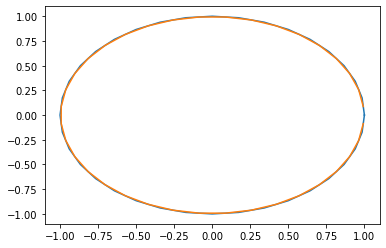

In [101]:
# To check the geometry created of the object in the flow
import matplotlib.pyplot as plt
plt.plot(XB,YB)
plt.plot(XC,YC)

In [102]:

    # Initialize arrays
    I = np.zeros([numP,numP])                                                   # Initialize I integral matrix
    J = np.zeros([numP,numP])                                                   # Initialize J integral matrix
    
    # Compute integral
    for i in range(numP):                                                         # Loop over i panels
        for j in range(numP):                                                     # Loop over j panels
            if (j != i):                                                            # If the i and j panels are not the same
                # Compute intermediate values
                A  = -(XC[i]-XB[j])*np.cos(phi[j])-(YC[i]-YB[j])*np.sin(phi[j])     # A term
                B  = (XC[i]-XB[j])**2 + (YC[i]-YB[j])**2                            # B term
                C = np.sin(phi[i]-phi[j])                                          # C term (normal)
                D = (YC[i]-YB[j])*np.cos(phi[i])-(XC[i]-XB[j])*np.sin(phi[i])      # D term (normal)
                E  = np.sqrt(B-A**2)                                                # E term
                if (E == 0 or np.iscomplex(E) or np.isnan(E) or np.isinf(E)):       # If E term is 0 or complex or a NAN or an INF
                    I[i,j] = 0                                                      # Set I value equal to zero
                    J[i,j] = 0                                                      # Set J value equal to zero
                else:
                    # Compute I (needed for normal velocity), Ref [1]
                    term1  = 0.5*C*np.log((S[j]**2 + 2*A*S[j] + B)/B)              # First term in I equation
                    term2  = ((D-A*C)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) # Second term in I equation
                    I[i,j] = term1 + term2                                          # Compute I integral
                    
                    # Compute J (needed for tangential velocity), Ref [2]
                    term1  = ((D-A*C)/(2*E))*np.log((S[j]**2 + 2*A*S[j] + B)/B)              # First term in J equation
                    term2  = ((-1)*C)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) # Second term in J equation
                    J[i,j] = term1 + term2                                          # Compute J integral
                
            # Zero out any problem values
            if (np.iscomplex(I[i,j]) or np.isnan(I[i,j]) or np.isinf(I[i,j])):      # If I term is complex or a NAN or an INF
                I[i,j] = 0                                                          # Set I value equal to zero
            if (np.iscomplex(J[i,j]) or np.isnan(J[i,j]) or np.isinf(J[i,j])):      # If J term is complex or a NAN or an INF
                J[i,j] = 0                                                          # Set J value equal to zero
            
            #if(i==3):
                    #print(math.degrees(phi[i])," ",math.degrees(phi[j])," ",XB[j]," ",XB[j+1]," ",YB[j]," ",YB[j+1]," ",XC[i]," ",YC[i]," ")
                    #print(A," ",B," ",Cn," ",Dn," ",E," ") ## SIGN ISSUE in C and D 
                    #print(I[i,j])
           
  #These are values of I and J.

In [103]:
# Using the above calculated values of I[i,j] and J[i,j],
# we form a matrix equation of the system of n equations and n variables (n=numP)
mat_I = np.zeros([numP,numP])                                        
mat_J = np.zeros([numP,numP])    

for i in range(numP):
    for j in range(numP):
        mat_J[i,j] = (J[i,j])/(2*math.pi)
        mat_I[i,j] = (I[i,j])/(2*math.pi)
        if(i==j):
            mat_I[i,j]=0.5
            mat_J[i,j]=0

#and the other matrix in the equation
b  = np.zeros(numP)                # Initialize control point X-coordinate

for i in range(numP):
    b[i] = Vinf*math.sin(phi[i])
    # to remove precision error
    if(-math.pow(10,-15) < b[i] < math.pow(10,-15)):
        b[i] = 0
print(b)

[-0.9961947  -0.96592583 -0.90630779 -0.81915204 -0.70710678 -0.57357644
 -0.42261826 -0.25881905 -0.08715574  0.08715574  0.25881905  0.42261826
  0.57357644  0.70710678  0.81915204  0.90630779  0.96592583  0.9961947
  0.9961947   0.96592583  0.90630779  0.81915204  0.70710678  0.57357644
  0.42261826  0.25881905  0.08715574 -0.08715574 -0.25881905 -0.42261826
 -0.57357644 -0.70710678 -0.81915204 -0.90630779 -0.96592583 -0.9961947 ]


In [104]:
# solving for strength

#strength = np.linalg.inv(mat_I).dot(b)
strength = np.linalg.solve(mat_I, b)

sum=0
for i in range(numP):
    sum = sum+strength[i]
    # to remove precision error
    if(-math.pow(10,-15) < strength[i] < math.pow(10,-15)):
        strength[i]=0

# to remove precision error
if(-math.pow(10,-15) < sum < math.pow(10,-15)):
    sum =0
    
print(sum)
print(strength)
#for equal area panels, sum of strenghths = 0 . If not, solution is wrong

7.993605777301127e-15
[-2.06963841 -2.0067535  -1.88289439 -1.70182449 -1.46904552 -1.19163034
 -0.87800807 -0.53770798 -0.1810699   0.1810699   0.53770798  0.87800807
  1.19163034  1.46904552  1.70182449  1.88289439  2.0067535   2.06963841
  2.06963841  2.0067535   1.88289439  1.70182449  1.46904552  1.19163034
  0.87800807  0.53770798  0.1810699  -0.1810699  -0.53770798 -0.87800807
 -1.19163034 -1.46904552 -1.70182449 -1.88289439 -2.0067535  -2.06963841]


In [105]:
# Solving for Vi

Vs  = np.zeros(numP)                # Initialize contribution of freestream velocity 
V  = np.zeros(numP)                # Initialize velocity over control points
Cp  = np.zeros(numP)                # Initialize pressure coefficients over control points


for i in range(numP):
    Vs[i] = Vinf*math.cos(phi[i])

V = np.matmul(mat_J,strength) + Vs
#print(V)

# Calculating Pressure Coefficient
for i in range(numP):
    Cp[i] = 1 - math.pow((V[i]/Vinf),2)
print(Cp)
print(phi)

[ 0.96961551  0.73205081  0.28557522 -0.31595971 -1.         -1.68404029
 -2.28557522 -2.73205081 -2.96961551 -2.96961551 -2.73205081 -2.28557522
 -1.68404029 -1.         -0.31595971  0.28557522  0.73205081  0.96961551
  0.96961551  0.73205081  0.28557522 -0.31595971 -1.         -1.68404029
 -2.28557522 -2.73205081 -2.96961551 -2.96961551 -2.73205081 -2.28557522
 -1.68404029 -1.         -0.31595971  0.28557522  0.73205081  0.96961551]
[4.62512252 4.45058959 4.27605667 4.10152374 3.92699082 3.75245789
 3.57792497 3.40339204 3.22885912 3.05432619 2.87979327 2.70526034
 2.53072742 2.35619449 2.18166156 2.00712864 1.83259571 1.65806279
 1.48352986 1.30899694 1.13446401 0.95993109 0.78539816 0.61086524
 0.43633231 0.26179939 0.08726646 6.19591884 6.02138592 5.84685299
 5.67232007 5.49778714 5.32325422 5.14872129 4.97418837 4.79965544]


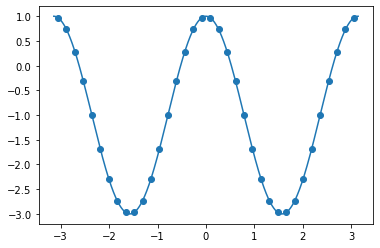

In [107]:
# Solving for Vi

Vs  = np.zeros(numP)                # Initialize contribution of freestream velocity 
V  = np.zeros(numP)                # Initialize velocity over control points
Cp  = np.zeros(numP)                # Initialize pressure coefficients over control points


for i in range(numP):
    Vs[i] = Vinf*math.cos(phi[i])

V = np.matmul(mat_J,strength) + Vs
#print(V)

# Calculating Pressure Coefficient
for i in range(numP):
    Cp[i] = 1 - math.pow((V[i]/Vinf),2)
#print(Cp)

angle_control_point = np.zeros(numP)                # Initialize panel orientation angle array
for i in range(numP):
    angle_control_point[i]  = math.atan2(YC[i],XC[i])               # Angle of panel 
plt.scatter(angle_control_point,Cp)
    
# Plotting the Analytical Function
import matplotlib.pyplot as plt
psi = np.linspace(-math.pi,1*math.pi,10000)
function  = np.zeros(10000)                # Initialize the Analytical function values 

for i in range(10000):
    function[i] = 1 - 4*math.pow(math.sin(psi[i]),2)
    
plt.plot(psi,function)